# Prepatation

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
from utils import ModelAndTokenizer, plot_scores, find_token_range
import matplotlib.pyplot as plt
import numpy as np
from causal_trace import plot_all_flow
import os, re, json
torch.set_grad_enabled(False)

In [3]:
model_name = "mistralai/Mistral-7B-Instruct-v0.1"  
device = "cuda:7"
mt = ModelAndTokenizer(model_name, device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Case1 (Country) (Capital,Currency,Area,Population,Religion,Language)

## 1.Location by CT

In [4]:
id = 8
data_path = "/home/zijianwang/ACL2024/country_capital_city.json"
with open(data_path, 'r') as file:
    data = json.load(file)
Template = data["Prompt"]
relation = data["Relation"]
subject = data["samples"][id]["subject"]
object = data["samples"][id]["object"]
print(f"Subject: {subject}, Relation: {relation}, Object: {object}")
print(Template)

Subject: Venezuela, Relation: capital city of this country, Object: Caracas
Given {}, the capital city of this country is


Tokens: ['<s>', ' Given', ' Venezuela', ',', ' the', ' capital', ' city', ' of', ' this', ' country', ' is']
Tokens: ['<s>', ' Given', ' Venezuela', ',', ' the', ' capital', ' city', ' of', ' this', ' country', ' is']
Plotting hs...
inp_ids=tensor([    1, 12628, 25307, 28725,   272,  5565,  2990,   302,   456,  2939,
          349], device='cuda:7')
inp_tokens: {0: '<s>', 1: '▁Given', 2: '▁Venezuela', 3: ',', 4: '▁the', 5: '▁capital', 6: '▁city', 7: '▁of', 8: '▁this', 9: '▁country', 10: '▁is'}
Answer is Car, Answer_id is 2364, Answer_token: ['▁Car'], base_score is 0.9427193403244019
noise_range : [5, 10]
Tracing 0/11 ,0/32
Tracing 0/11 ,1/32
Tracing 0/11 ,2/32
Tracing 0/11 ,3/32
Tracing 0/11 ,4/32
Tracing 0/11 ,5/32
Tracing 0/11 ,6/32
Tracing 0/11 ,7/32
Tracing 0/11 ,8/32
Tracing 0/11 ,9/32
Tracing 0/11 ,10/32
Tracing 0/11 ,11/32
Tracing 0/11 ,12/32
Tracing 0/11 ,13/32
Tracing 0/11 ,14/32
Tracing 0/11 ,15/32
Tracing 0/11 ,16/32
Tracing 0/11 ,17/32
Tracing 0/11 ,18/32
Tracing 0/11 ,19/3

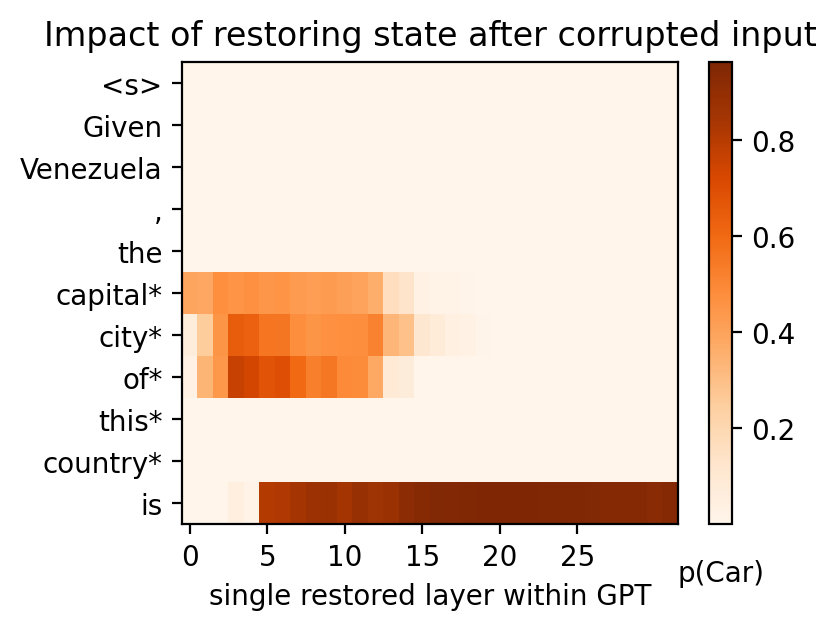

--------------------------------------------------
Plotting hs...
inp_ids=tensor([    1, 12628, 25307, 28725,   272,  5565,  2990,   302,   456,  2939,
          349], device='cuda:7')
inp_tokens: {0: '<s>', 1: '▁Given', 2: '▁Venezuela', 3: ',', 4: '▁the', 5: '▁capital', 6: '▁city', 7: '▁of', 8: '▁this', 9: '▁country', 10: '▁is'}
Answer is Car, Answer_id is 2364, Answer_token: ['▁Car'], base_score is 0.9427193403244019
noise_range : [2, 3]
Tracing 0/11 ,0/32
Tracing 0/11 ,1/32
Tracing 0/11 ,2/32
Tracing 0/11 ,3/32
Tracing 0/11 ,4/32
Tracing 0/11 ,5/32
Tracing 0/11 ,6/32
Tracing 0/11 ,7/32
Tracing 0/11 ,8/32
Tracing 0/11 ,9/32
Tracing 0/11 ,10/32
Tracing 0/11 ,11/32
Tracing 0/11 ,12/32
Tracing 0/11 ,13/32
Tracing 0/11 ,14/32
Tracing 0/11 ,15/32
Tracing 0/11 ,16/32
Tracing 0/11 ,17/32
Tracing 0/11 ,18/32
Tracing 0/11 ,19/32
Tracing 0/11 ,20/32
Tracing 0/11 ,21/32
Tracing 0/11 ,22/32
Tracing 0/11 ,23/32
Tracing 0/11 ,24/32
Tracing 0/11 ,25/32
Tracing 0/11 ,26/32
Tracing 0/11 ,27/32
Tracin

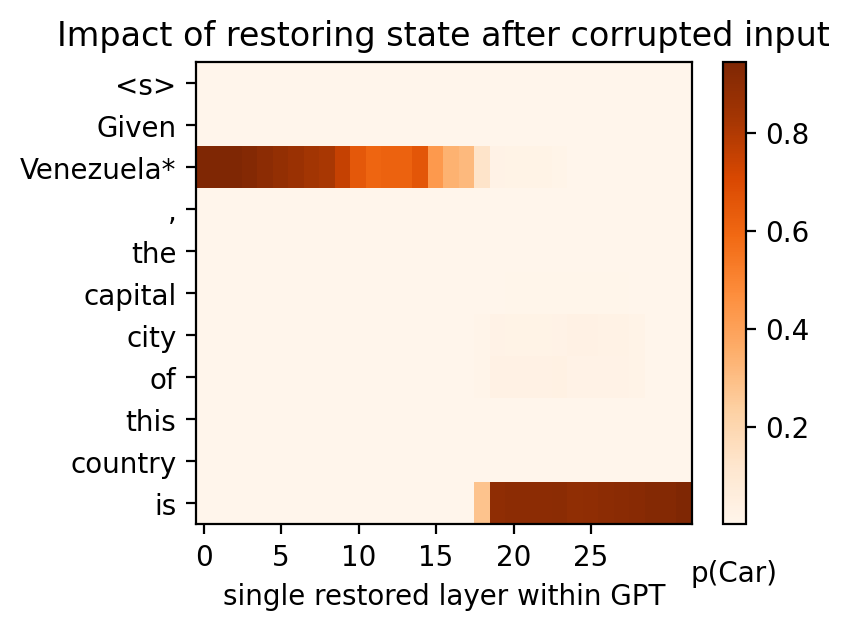

In [7]:
Recall_prompt = Template.format(subject)
token_range_sub = find_token_range(mt.tokenizer, Recall_prompt, subject)
token_range_rel = find_token_range(mt.tokenizer, Recall_prompt, relation)
# token_range_rel[1] = token_range_rel[1] + 3

res_dict_no_rel = plot_all_flow(mt, Recall_prompt, subject = None, noise = 1, type = None, noise_range = token_range_rel)
print("--------------------------------------------------")
res_dict_no_sub  = plot_all_flow(mt, Recall_prompt, subject = None, noise = 1, type = None, noise_range = token_range_sub)


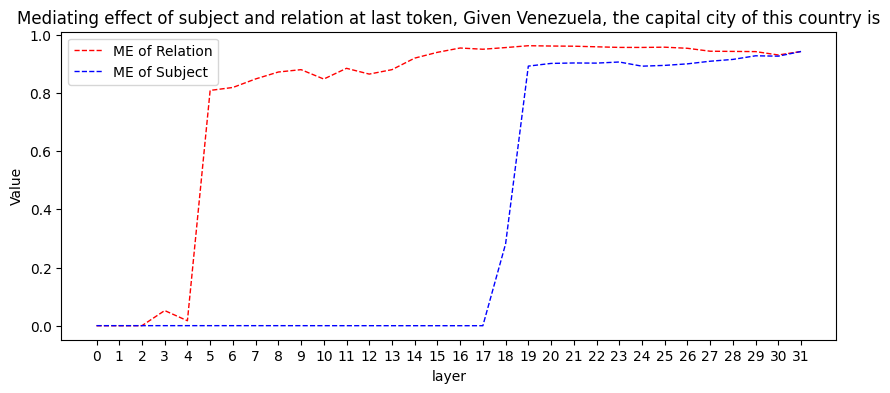

In [8]:
score_no_rel = res_dict_no_rel["hs"]['scores'][-1]
score_no_sub = res_dict_no_sub["hs"]['scores'][-1]
# score_no_instructs.append(score_no_instruct)
# score_no_inputs.append(score_no_input)
title = f"Mediating effect of subject and relation at last token, {Recall_prompt}"
plot_scores(score_no_rel, score_no_sub, title)

In [9]:
diff = torch.abs(score_no_rel - score_no_sub)
threshold = 0.4
big_diff_mask = diff > threshold
start_idx = torch.where(big_diff_mask)[0][0] if torch.any(big_diff_mask) else None
end_idx = torch.where(big_diff_mask)[0][-1]  if torch.any(big_diff_mask) else None
Range = (int(start_idx), int(end_idx))
if start_idx is None or end_idx is None:
    print("No Relation Emergence Stage Found (diff > threshold)!")
else:
    print(f"Relation Emergence Stage: {Range}")

Relation Emergence Stage: (5, 18)


## Zero shot

In [17]:
from util.locating_extracting import zero_shot, edit

In [18]:
acc_zs, acc_full, good_cases = zero_shot(mt, data_path, Recall_prompt, layer_range = Range)

subject:United States,object:Washington D.C.
Input:Given Uganda,
progress:0/253
Sub: Uganda
Result_ZS:True, ZS Obj: Kampala.</s></s></s>, True Obj: Kampala
Result_Full:True, Full Obj: Kampala. Kampala is, True Obj: Kampala
acc_zs:0.003952569169960474, acc_full:0.003952569169960474
--------------------------------------------------------------
Input:Given Venezuela,
progress:1/253
Sub: Venezuela
Result_ZS:True, ZS Obj: Caracas.

, True Obj: Caracas
Result_Full:True, Full Obj: Caracas. Carac, True Obj: Caracas
acc_zs:0.007905138339920948, acc_full:0.007905138339920948
--------------------------------------------------------------
Input:Given Cambodia,
progress:2/253
Sub: Cambodia
Result_ZS:True, ZS Obj: Phnom Penh.
, True Obj: Phnom Penh
Result_Full:True, Full Obj: Phnom Penh. This, True Obj: Phnom Penh
acc_zs:0.011857707509881422, acc_full:0.011857707509881422
--------------------------------------------------------------
Input:Given French Guiana,
progress:3/253
Sub: French Guiana
Resu

In [19]:
import pickle
goog_cases_path = "good_cases_{}.pkl".format(data["name"])
with open(goog_cases_path , 'wb') as f:
    pickle.dump(good_cases, f)


In [20]:
good_data = pickle.load(open(goog_cases_path, "rb"))
print(good_data)
print(len(good_data))

[{'Subject': 'Uganda', 'Predict_Obj': 'Kampala. Kampala is', 'True_Obj': 'Kampala'}, {'Subject': 'Venezuela', 'Predict_Obj': 'Caracas. Carac', 'True_Obj': 'Caracas'}, {'Subject': 'Cambodia', 'Predict_Obj': 'Phnom Penh. This', 'True_Obj': 'Phnom Penh'}, {'Subject': 'French Guiana', 'Predict_Obj': 'Cayenne. Cay', 'True_Obj': 'Cayenne'}, {'Subject': 'Slovenia', 'Predict_Obj': 'Ljubljana.', 'True_Obj': 'Ljubljana'}, {'Subject': 'Finland', 'Predict_Obj': 'Helsinki. This', 'True_Obj': 'Helsinki'}, {'Subject': 'Germany', 'Predict_Obj': 'Berlin. Berlin is a city', 'True_Obj': 'Berlin'}, {'Subject': 'Saint Lucia', 'Predict_Obj': 'Castries. This city is', 'True_Obj': 'Castries'}, {'Subject': 'San Marino', 'Predict_Obj': 'San Marino. It is', 'True_Obj': 'San Marino'}, {'Subject': 'Russia', 'Predict_Obj': 'Moscow. Moscow is the largest', 'True_Obj': 'Moscow'}, {'Subject': 'Luxembourg', 'Predict_Obj': 'Luxembourg City. It is', 'True_Obj': 'Luxembourg'}, {'Subject': 'Seychelles', 'Predict_Obj': 'Vic

In [21]:
acc = edit(mt, good_data, Recall_prompt, relation, layer_range = Range)

Input: What is the contrast of Uganda?
Input_modify: What is the contrast of Uganda? Actually, I am asking its capital city of this country
progress:0/231
Sub: Uganda
Result:True
 Edit_Obj: Kampala.</s></s></s>, Modify_obj: .

## Answer (, True_Obj: Kampala
acc:0.004329004329004329, acc_modify:0.0
--------------------------------------------------------------
Input: What is the connection of Venezuela?
Input_modify: What is the connection of Venezuela? Actually, I am asking its capital city of this country
progress:1/231
Sub: Venezuela
Result:True
 Edit_Obj: Caracas?

, Modify_obj: .

Comment: Venezuela, True_Obj: Caracas
acc:0.008658008658008658, acc_modify:0.0
--------------------------------------------------------------
Input: What is the flexibility of Cambodia?
Input_modify: What is the flexibility of Cambodia? Actually, I am asking its capital city of this country
progress:2/231
Sub: Cambodia
Result:True
 Edit_Obj: Phnom Penh.</s>, Modify_obj: .

Comment: I, True_Obj: Phnom Penh

In [14]:
print(acc_zs, acc_full)

0.8142292490118577 0.9169960474308301


In [11]:
import numpy as np
import scipy.stats as st

# generate observed data
X = st.norm(loc=3, scale=1).rvs(size=1000)
print(X)

[2.3486 2.5161 2.6797 3.4242 3.5228 2.4263 2.9756 5.1423 4.7275 3.4363
 3.038  3.12   3.6135 1.9772 2.7426 1.3314 3.3992 3.6472 2.5168 4.574
 1.7742 1.5356 3.2245 4.0471 4.6839 2.5411 4.0787 2.9615 2.8274 3.8837
 3.6523 1.4236 4.4765 4.3801 2.3744 3.3958 3.494  3.2607 2.4497 2.3284
 2.9744 4.1727 3.5436 2.6294 3.7717 0.1515 4.1488 1.2603 2.6376 1.8803
 1.7053 4.1608 2.5323 3.3465 2.9531 3.477  3.0768 1.717  3.9963 2.5062
 1.4434 2.5719 4.5008 3.8502 2.6513 2.6507 2.6784 5.0767 3.3819 3.43
 4.0303 3.2388 2.741  2.8037 2.9284 2.9628 3.7276 3.0519 3.7326 2.9193
 3.0786 1.0018 3.9163 3.3465 3.998  0.1037 5.0884 2.8604 4.1082 1.9601
 3.6128 1.9466 2.3762 4.914  2.8093 3.2174 3.8701 3.4957 3.1504 3.365
 5.4034 2.9424 3.2011 4.0507 4.1055 4.187  3.6387 1.857  4.6334 1.8537
 3.3026 2.2457 2.9359 3.3288 3.3214 3.4219 4.6137 3.4535 2.7558 3.9641
 4.1895 1.7724 3.5974 3.7012 2.7024 4.3757 2.8499 3.1256 2.8269 3.0156
 1.9037 1.5599 4.5945 2.153  2.0086 0.8466 2.361  1.6769 4.642  4.0098
 2.3118 5.

In [16]:
import numpy as np
import scipy.stats as st

# generate observed data
X = st.norm(loc=3, scale=1).rvs(size=1000)
print(X)

def guassian_posterior(X, theta):
    # returns the unnormalized log posterior
    loglik = np.sum(np.log(st.norm(loc=theta, scale=1).pdf(X)))
    logprior = np.log(st.norm(loc=0, scale=1).pdf(theta))
    
    return loglik + logprior
    
def guassian_proposal(theta_curr):
    # proposal based on Gaussian
    theta_new = st.norm(loc=theta_curr, scale=0.2).rvs()
    return theta_new

def guassian_proposal_prob(x1, x2):
    # calculate proposal probability q(x2|x1), based on Gaussian
    q = st.norm(loc=x1, scale=1).pdf(x2)
    return q

def mcmc_mh_posterior(X, theta_init, func, proposal_func, proposal_func_prob, n_iter=1000):
    # Metropolis-Hastings to estimate posterior
    thetas = []
    theta_curr = theta_init
    accept_rates = []
    accept_cum = 0
    
    for i in range(1, n_iter+1):
        theta_new = proposal_func(theta_curr)
        
        prob_curr = func(X, theta_curr)
        prob_new = func(X, theta_new)
        
        # we calculate the prob=exp(x) only when prob<1 so the exp(x) will not overflow for large x
        if prob_new > prob_curr:
            acceptance_ratio = 1
        else:
            qr = proposal_func_prob(theta_curr, theta_new)/proposal_func_prob(theta_new, theta_curr)
            acceptance_ratio = np.exp(prob_new - prob_curr) * qr
        acceptance_prob = min(1, acceptance_ratio)
        
        if acceptance_prob > st.uniform(0,1).rvs():
            print("Accept")
            theta_curr = theta_new
            accept_cum = accept_cum+1
            thetas.append(theta_new)
        else:
            print("Reject")
            thetas.append(theta_curr)
            
        accept_rates.append(accept_cum/i)
        
    return thetas, accept_rates

# run MCMC
thetas, accept_rates = mcmc_mh_posterior(X, 1, 
                                         jir, guassian_proposal, guassian_proposal_prob, 
                                         n_iter=8000)

Reject
Reject
Reject
Reject
Accept
Accept
Accept
Accept
Accept
Reject
Reject
Reject
Accept
Reject
Accept
Reject
Reject
Reject
Reject
Reject
Reject
Accept
Accept
Reject
Reject
Reject
Accept
Reject
Accept
Accept
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Accept
Reject
Reject
Accept
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Accept
Accept
Reject
Accept
Reject
Reject
Reject
Reject
Accept
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Accept
Accept
Reject
Accept
Accept
Reject
Accept
Reject
Reject
Reject
Reject
Accept
Reject
Reject
Accept
Reject
Reject
Accept
Reject
Reject
Reject
Accept
Accept
Reject
Reject
Reject
Reject
Reject
Reject
Accept
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Accept
Reject
Accept
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Reject
Accept
Reject
Reject
Accept
Accept
Reject
Reject
Reject
Accept
Accept
Reject
Accept
Reject
Reject
Reject
Reject
Reject
Reject

In [17]:
print(thetas)

[1, 1, 1, 1, 1.0284809733256264, 1.2513278426741472, 1.3867339366343086, 1.562936606067349, 1.780120288368693, 1.780120288368693, 1.780120288368693, 1.780120288368693, 1.9264547536928753, 1.9264547536928753, 2.212804650541091, 2.212804650541091, 2.212804650541091, 2.212804650541091, 2.212804650541091, 2.212804650541091, 2.212804650541091, 2.427923632180757, 2.490781495276498, 2.490781495276498, 2.490781495276498, 2.490781495276498, 2.5013693889234583, 2.5013693889234583, 2.8568983526873444, 3.032139551021676, 3.032139551021676, 3.032139551021676, 3.032139551021676, 3.032139551021676, 3.032139551021676, 3.032139551021676, 3.032139551021676, 3.032139551021676, 3.032139551021676, 3.032139551021676, 3.032139551021676, 3.032139551021676, 3.0632746285593537, 3.0632746285593537, 3.0632746285593537, 3.100450205283807, 3.100450205283807, 3.100450205283807, 3.100450205283807, 3.100450205283807, 3.100450205283807, 3.100450205283807, 3.100450205283807, 3.032485971622148, 3.0689129458243833, 3.0689

In [24]:
import numpy as np
import scipy.stats as st

# generate observed data from a mixture of two Gaussians
X = np.concatenate([
    st.norm(loc=10, scale=0.6).rvs(size=500),
    st.norm(loc=1, scale=0.7).rvs(size=500)
])

print(X)

def mixture_posterior(X, theta):
    # returns the unnormalized log posterior
    loglik1 = np.sum(np.log(st.norm(loc=theta[0], scale=1).pdf(X)))
    loglik2 = np.sum(np.log(st.norm(loc=theta[1], scale=1).pdf(X)))
    loglik = np.logaddexp(loglik1, loglik2) - np.log(2)
    logprior = np.sum(np.log(st.norm(loc=0, scale=3).pdf(theta)))
    return loglik + logprior

def mixture_proposal(theta_curr):
    # proposal based on Gaussian
    theta_new = st.multivariate_normal(mean=theta_curr, cov=0.5*np.eye(2)).rvs()
    return theta_new

def mixture_proposal_prob(x1, x2):
    # calculate proposal probability q(x2|x1), based on Gaussian
    q = st.multivariate_normal(mean=x1, cov=0.5*np.eye(2)).pdf(x2)
    return q

def mcmc_mh_posterior(X, theta_init, func, proposal_func, proposal_func_prob, n_iter=1000):
    # Metropolis-Hastings to estimate posterior
    thetas = []
    theta_curr = theta_init
    accept_rates = []
    accept_cum = 0

    for i in range(1, n_iter+1):
        theta_new = proposal_func(theta_curr)
        prob_curr = func(X, theta_curr)
        prob_new = func(X, theta_new)

        # we calculate the prob=exp(x) only when prob<1 so the exp(x) will not overflow for large x
        if prob_new > prob_curr:
            acceptance_ratio = 1
        else:
            qr = proposal_func_prob(theta_curr, theta_new)/proposal_func_prob(theta_new, theta_curr)
            acceptance_ratio = np.exp(prob_new - prob_curr) * qr

        acceptance_prob = min(1, acceptance_ratio)

        if acceptance_prob > st.uniform(0,1).rvs():
            print("Accept")
            theta_curr = theta_new
            accept_cum = accept_cum+1
        else:
            print("Reject")

        thetas.append(theta_curr)
        accept_rates.append(accept_cum/i)

    return thetas, accept_rates

# run MCMC
thetas, accept_rates = mcmc_mh_posterior(X, [0, 0],
                                         mixture_posterior, mixture_proposal, mixture_proposal_prob,
                                         n_iter=9000)

[ 1.0035e+01  1.0885e+01  1.0674e+01  1.0274e+01  1.0413e+01  1.0175e+01
  9.4402e+00  1.0643e+01  1.1211e+01  1.0303e+01  9.9277e+00  9.5638e+00
  9.8458e+00  9.2352e+00  9.4510e+00  9.8996e+00  1.0190e+01  9.1147e+00
  1.0115e+01  1.0950e+01  1.0261e+01  1.0297e+01  1.0244e+01  9.0398e+00
  9.0928e+00  1.0359e+01  1.0426e+01  1.0627e+01  1.0810e+01  9.6901e+00
  1.0582e+01  1.0574e+01  1.0922e+01  1.0962e+01  9.7662e+00  9.9523e+00
  1.0125e+01  9.5037e+00  1.0665e+01  9.8727e+00  1.0701e+01  1.0908e+01
  9.8306e+00  8.9527e+00  9.9828e+00  1.0802e+01  1.0794e+01  9.9397e+00
  1.0073e+01  9.9085e+00  9.6438e+00  8.9706e+00  1.0312e+01  9.7099e+00
  1.0129e+01  1.0407e+01  1.0542e+01  9.5871e+00  9.4140e+00  1.0353e+01
  1.0397e+01  9.6619e+00  1.0597e+01  9.9772e+00  9.5541e+00  9.4101e+00
  1.0293e+01  1.0144e+01  1.0228e+01  9.3364e+00  8.6649e+00  1.0366e+01
  1.0720e+01  9.0285e+00  9.7475e+00  1.1584e+01  1.0338e+01  1.0785e+01
  1.0978e+01  9.7095e+00  1.1405e+01  8.9572e+00  1

In [25]:
print(thetas)

[array([ 0.0946, -0.7291]), array([ 0.0946, -0.7291]), array([ 1.1205, -1.444 ]), array([ 2.2987, -1.5597]), array([ 2.4366, -1.2382]), array([ 2.709 , -1.4698]), array([ 2.709 , -1.4698]), array([ 2.709 , -1.4698]), array([ 2.709 , -1.4698]), array([ 3.0476, -1.8549]), array([ 3.5834, -1.2873]), array([ 3.9657, -1.4087]), array([ 4.8913, -2.4641]), array([ 4.8913, -2.4641]), array([ 4.8913, -2.4641]), array([ 4.8913, -2.4641]), array([ 6.0293, -3.5393]), array([ 6.0293, -3.5393]), array([ 6.0293, -3.5393]), array([ 5.1944, -3.1446]), array([ 5.1944, -3.1446]), array([ 5.1944, -3.1446]), array([ 5.1944, -3.1446]), array([ 5.4004, -3.8243]), array([ 5.4004, -3.8243]), array([ 5.4004, -3.8243]), array([ 5.4453, -4.1292]), array([ 5.4749, -4.2879]), array([ 5.4749, -4.2879]), array([ 5.4749, -4.2879]), array([ 5.4749, -4.2879]), array([ 5.4749, -4.2879]), array([ 5.4749, -4.2879]), array([ 5.4749, -4.2879]), array([ 5.4749, -4.2879]), array([ 5.4749, -4.2879]), array([ 5.4749, -4.2879]), 